# **Exit Choice Models**

This notebook describes two models for computing an agent's probability of selecting an exit based on **distance, congestion, flow, and visibility**.

**Reference**
> Haghani M,Sarvi M,Shahhoseini Z, Boltes M(2016) HowSimple Hypothetical-Choice Experiments CanBeUtilized toLearn Humans’ NavigationalEscape Decisions inEmergenc ies. PLoS ONE11(11): e0166908. doi:10.1371/journal. pone.0166908

---

## **Model 1: Standard Flow-Based Choice**

This model considers the effect of **flow only when the exit is visible**. The utility function is:

$$
U_i = \beta_1 \cdot \text{DIST}_i + \beta_2 \cdot \text{CONG}_i + \beta_3 \cdot (\text{FLTOEXIT}_i \cdot \text{VIS}_i)
$$

where:

- $ \text{DIST}\_i $ : Distance to exit $ i $ (negative effect)
- $ \text{CONG}\_i $ : Congestion at exit $ i $ (negative effect)
- $ \text{FLTOEXIT}\_i $ : Flow to exit $ i $ (positive or negative depending on $ \beta_3 $
- $ \text{VIS}\_i $ : Visibility indicator (1 if visible, 0 otherwise)
- $ \beta_1, \beta_2, \beta_3 $ : Model parameters

In this model, **flow is ignored for non-visible exits**, meaning that agents only react to visible movement patterns.

---

## **Model 2: Visibility-Specific Flow Sensitivity**

This model **differentiates the effect of flow** based on whether the exit is visible or not. The utility function is:

$$
U_i = \beta_1 \cdot \text{DIST}_i + \beta_2 \cdot \text{CONG}_i + \beta_3 \cdot (\text{FLTOEXIT}_i \cdot \text{VIS}_i) + \beta_4 \cdot (\text{FLTOEXIT}_i \cdot (1 - \text{VIS}_i))
$$

where:

- $ \beta_4 $ allows **flow to have a different influence when the exit is not visible**.
- If ** $ \beta_3 = \beta_4 $**, the model is equivalent to **Model 1**.
- This model accounts for the possibility that agents may still infer congestion even when they **cannot directly see** an exit.

---

## **Choosing Between Models**

- **If agents primarily react to visible flow**, Model 1 is sufficient.
- **If agents are influenced by unseen movement (e.g., hearing or indirect cues)**, Model 2 provides a more nuanced approach.
- Model 2 allows testing whether unseen flow has a **weaker, equal, or stronger** influence compared to visible flow.


In [39]:
import jupedsim as jps
from jupedsim.internal.notebook_utils import animate, read_sqlite_file
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point, LineString
import numpy as np
import random
from pathlib import Path

# Define Geometry

In [40]:
geometry_file = "sample_data/routing.wkt"
if Path(geometry_file).exists():
    with open(geometry_file, "r") as myfile:
        data = myfile.read().strip()

    # Load the main GEOMETRYCOLLECTION
    geometry_collection = wkt.loads(data)
else:
    geometry_collection = wkt.loads("GEOMETRYCOLLECTION (GEOMETRYCOLLECTION (POLYGON ((-5 -13, -5 -3, 0 -3, 0 12, 2 12, 2 13, -2 13, -2 16, 12 16, 12 13, 8 13, 8 12, 12 12, 12 8, 13 8, 13 10, 16 10, 16 6, 13 6, 13 7, 12 7, 12 6, 8 6, 5 3, 5 -3, 10 -3, 10 -13, -5 -13), (6 10, 4 10, 4 8, 6 8, 6 10), (7 12, 7 13, 3 13, 3 12, 7 12))), GEOMETRYCOLLECTION (POLYGON ((14 7, 14 8, 15 8, 15 7, 14 7)), POLYGON ((-1.7 14.8, -1.7 15.8, -0.7 15.8, -0.7 14.8, -1.7 14.8)), POLYGON ((10.7 14.8, 10.7 15.8, 11.7 15.8, 11.7 14.8, 10.7 14.8))), GEOMETRYCOLLECTION (POLYGON ((-4 -12, -4 -4, 9 -4, 9 -12, -4 -12))))")
# Extract main collections
polygons = list(geometry_collection.geoms)  # Unpack main-level geometries

# Extract walkable area
area = polygons[0]  # if len(polygons) > 0 else None

# Extract exits (second collection)
exit_polygons = []
if len(polygons) > 1:
    exits = polygons[1]  # GEOMETRYCOLLECTION of exits
    exit_polygons = list(exits.geoms)

# Extract distributions (third collection)
distribution_polygons = []
if len(polygons) > 2:
    distributions = polygons[2]  # GEOMETRYCOLLECTION of distributions
    distribution_polygons = list(distributions.geoms)

print(f"Exits: {len(exit_polygons)} polygons")
print(f"Distributions: {len(distribution_polygons)} polygons")

Exits: 3 polygons
Distributions: 1 polygons


In [41]:
def plot_geometry(geometry_collection, positions=None):
    """Plot the geometry collection with different colors for each geometry type."""
    fig, ax = plt.subplots(figsize=(8, 8))
    if geometry_collection.is_empty:
        print("Skipping empty geometry.")
        return
    polygons = list(geometry_collection.geoms)  # Unpack main-level geometries
    area = polygons[0] if len(polygons) > 0 else None
    # Extract exits (second collection)
    if len(polygons) > 1:
        exits = polygons[1]

    # Extract distributions (third collection)
    if len(polygons) > 2:
        distributions = polygons[2]

    for geom in area.geoms:
        x, y = geom.exterior.xy
        plt.fill(x, y, alpha=0.1, color="gray")
        for hole in geom.interiors:
            hx, hy = hole.xy
            ax.fill(hx, hy, alpha=1, edgecolor="white", facecolor="white")

    for e in exits.geoms:
        x, y = e.exterior.xy
        plt.fill(x, y, alpha=0.3, color="red")

    for d in distributions.geoms:
        x, y = d.exterior.xy
        plt.fill(x, y, alpha=0.3, color="green")

    for position in positions:
        x, y = position[0], position[1]
        plt.plot(x, y, "o", color="blue")

    legend_elements = {
        "area": mpatches.Patch(color="gray", label="Walkable Area"),
        "exits": mpatches.Patch(color="red", label="Exits"),
        "distribution": mpatches.Patch(color="green", label="Distribution Zones"),
    }
    handles = [
        legend_elements[key]
        for key in ["area", "exits", "distribution"]
        if key in legend_elements
    ]
    ax.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=len(handles),
        frameon=False,
    )
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    plt.show()

# Define Simulation, Exits and Distribute agents

In [42]:
num_agents = 100
simulation = jps.Simulation(
    #model=jps.CollisionFreeSpeedModel(),
    model=jps.SocialForceModel(),
    geometry=area,
    trajectory_writer=jps.SqliteTrajectoryWriter(output_file="trajectories.sqlite"),
)
exit_ids = []
for e in exit_polygons:
    exit_id = simulation.add_exit_stage(e)
    exit_ids.append(exit_id)

journey_ids = {}
for exit_id in exit_ids:
    journey = jps.JourneyDescription([exit_id])
    journey_id = simulation.add_journey(journey)
    journey_ids[exit_id] = journey_id

positions = jps.distributions.distribute_by_number(
    polygon=distribution_polygons[0],
    number_of_agents=num_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.15,
    seed=1234,
)

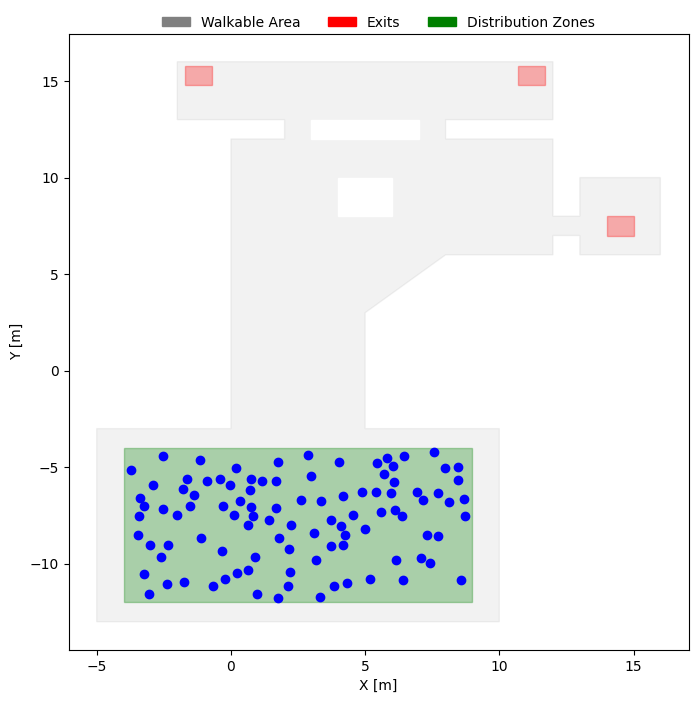

In [43]:
plot_geometry(geometry_collection, positions)

# Assign Exits

In [44]:
N2 = len(positions)
i = 0  # 0: right down exit. 1: left up exit. 2: right up exit
j = 1
k = 2
num_agents_per_exit = N2 // 3  # Integer division
remaining_agents = N2 % 3  # Handle remainder

# Define exit indices
exit_indices = [i, j, k]
# Track agent index
agent_idx = 0
for idx, exit_id in enumerate(exit_indices):
    num_agents = num_agents_per_exit + (
        1 if idx < remaining_agents else 0
    )  # Distribute remainder fairly

    for _ in range(num_agents):
        simulation.add_agent(
            #jps.CollisionFreeSpeedModelAgentParameters(
            jps.SocialForceModelAgentParameters(
                position=positions[agent_idx],
                stage_id=exit_ids[exit_id],
                journey_id=journey_ids[exit_ids[exit_id]],
                radius=0.15,
                desiredSpeed=1.34,
            )
        )
        agent_idx += 1

# Define Models

In [45]:
def distance(agent_position: Point, exit_point: Point) -> float:
    """Calculate the distance between an agent and an exit."""
    p1 = agent_position  # Point(agent_position.x, agent_position.y)
    return p1.distance(exit_point)

In [46]:
def congestion(simulation, radius):
    """Count how many agents are within a given radius around each exit."""
    congestion = {}

    for exit_id, exit_polygon in zip(exit_ids, exit_polygons):
        exit_point = exit_polygon.centroid
        congestion[exit_id] = 0  # Initialize count
        # print(f"\nChecking Exit {exit_id} at {exit_point}")
        for agent in simulation.agents():
            agent_pos = Point(agent.position)  # Convert agent position to Point
            dist = distance(exit_point, agent_pos)
            # print(f"Agent {agent.id} at {agent_pos}, Distance to exit: {dist}, Radius: {radius}")
            if dist <= radius:
                congestion[exit_id] += 1
                # print(f"  -> Agent {agent.id} is within radius!")

        # print(f"Total agents near Exit {exit_id}: {congestion[exit_id]}\n")

    return congestion

In [47]:
def flow(simulation):
    flow = {}
    for agent in simulation.agents():
        if agent.stage_id in flow:
            flow[agent.stage_id] += 1
        else:
            flow[agent.stage_id] = 1
    return flow

In [48]:
def visibility(point, exit_point, area):
    """Check if there is a clear line-of-sight between a point and the exit.
    Returns True if visible, False if blocked by the area geometry.
    """
    line_of_sight = LineString([point, exit_point])
    polygon_coords = list(area.geoms[0].exterior.coords)
    # Check each segment of the boundary
    for i in range(len(polygon_coords) - 1):
        segment = LineString([polygon_coords[i], polygon_coords[i + 1]])
        if line_of_sight.intersects(segment):
            # print(
            #    f"Line intersects polygon segment from {polygon_coords[i]} to {polygon_coords[i+1]}"
            # )
            # print(f"Intersection: {line_of_sight.intersection(segment)}")
            return False

    # Also check the interior rings (holes) if any
    for interior in area.geoms[0].interiors:
        interior_coords = list(interior.coords)
        for i in range(len(interior_coords) - 1):
            segment = LineString([interior_coords[i], interior_coords[i + 1]])
            if line_of_sight.intersects(segment):
                # print(
                #    f"Line intersects hole segment from {interior_coords[i]} to {interior_coords[i+1]}"
                # )
                # print(f"Intersection: {line_of_sight.intersection(segment)}")
                return False
    return True

In [49]:
def compute_agent_exit_probabilities(
    agent,
    area,
    exit_ids,
    exit_polygons,
    beta_dist,
    beta_cong,
    beta_flow,
    beta_flow_invis,
    radius,
    simulation,
    model_type="model1",
):
    """Compute the probability of a single agent choosing each exit using a logit model.
    Supports different model types: 'model1' (single flow term) or 'model2' (separate flow terms for visible/invisible exits).
    """
    congestion_counts = congestion(simulation, radius=radius)
    flow_counts = flow(simulation)
    utilities = {}
    debug = 0
    for exit_id, exit_polygon in zip(exit_ids, exit_polygons):
        exit_point = exit_polygon.centroid
        dist = distance(Point(agent.position), exit_point)
        cong = congestion_counts.get(exit_id, 0)
        flw = flow_counts.get(exit_id, 0)
        vis = 1 if visibility(Point(agent.position), exit_point, area) else 0
        # debug agent position, vis. exit point, flw
        if debug:
            print(
                f"Agent {agent.id} at {agent.position}, Exit {exit_id} at {exit_point}, Distance: {dist:.2f}, Congestion: {cong}, Flow: {flw}, Visibility: {vis}"
            )
            print(
                "Agent {agent.id}. result: ",
                beta_dist * dist
                + beta_cong * cong
                + beta_flow * (flw * vis)
                + beta_flow_invis * (flw * (1 - vis)),
            )
        if model_type == "model1":
            # Simplified model: Flow only when visible
            utilities[exit_id] = (
                beta_dist * dist + beta_cong * cong + beta_flow * (flw * vis)
            )
        elif model_type == "model2":

            utilities[exit_id] = (
                beta_dist * dist
                + beta_cong * cong
                + beta_flow * (flw * vis)
                + beta_flow_invis * (flw * (1 - vis))
            )
        else:
            raise ValueError("Invalid model_type. Choose 'model1' or 'model2'.")

    # Compute probabilities using softmax
    exp_utilities = {eid: np.exp(U) for eid, U in utilities.items()}
    sum_exp_U = sum(exp_utilities.values())
    probabilities = {eid: exp_utilities[eid] / sum_exp_U for eid in utilities.keys()}

    return probabilities

# Update Exit choices

In [50]:
# Dictionary to track commitment time per agent
commitment_time = {}
def update_exit_choices(simulation, journey_ids, probabilities, min_commit_time=5):
    """Update agent exit choices with inertia (commitment time)."""
    global commitment_time  # Store commitment times

    for agent in simulation.agents():
        max_prob = max(probabilities.values())

        # Identify all exits with the highest probability
        best_exits = [eid for eid, prob in probabilities.items() if prob == max_prob]
        # print(f"{agent.id = } {max_prob = }, {best_exits = }")

        # Case 1: If multiple exits have the same probability, randomly select one
        if len(best_exits) > 1 and max_prob > 0:
            # Randomly select one if multiple exits have the same probability
            new_exit_id = random.choice(best_exits)
            # print("Case 1: ", new_exit_id)

        # Case 2: If all probabilities are zero, skip switching
        if len(best_exits) > 1 and max_prob == 0:
            continue  # Prevents unnecessary switching when probabilities are tied

        # Case 3: If there is a single best choice, select it
        if len(best_exits) == 1:
            new_exit_id = best_exits[0]  # Choose the best exit (single highest)
            # print("Case 3: ", new_exit_id)
        # Ensure the agent stays committed for min_commit_time steps
        if agent.id in commitment_time:
            if commitment_time[agent.id] > 0:
                commitment_time[agent.id] -= 1  # Decrease counter
                continue  # Skip switching

        # Skip switch if the agent is already at the best exit
        if new_exit_id == agent.stage_id:
            continue

        # Commit agent to the new exit and reset the commitment timer
        simulation.switch_agent_journey(agent.id, journey_ids[new_exit_id], new_exit_id)
        commitment_time[agent.id] = min_commit_time  # Reset commitment timer

# Main Simulation Loop with Parameters

In [51]:
beta_dist = -0.0
beta_cong = -0.0
beta_flow = 0
beta_flow_invis = 0
radius = 4 # Radius in meter for congestion calculation
min_commit_time = 5 # Minimum commitment time in seconds. Avoid oscillations
decision_frequency = 10  # Update exit choices every N seconds
model = "model2"
while simulation.agent_count() > 0 and simulation.iteration_count() < 10000:
    simulation.iterate()
    if simulation.elapsed_time() % decision_frequency == 0:
        print(f"Time: {simulation.elapsed_time()}s", end="\r")
        for agent in simulation.agents():
            probabilities = compute_agent_exit_probabilities(
                agent,
                area,
                exit_ids,
                exit_polygons,
                model_type=model,
                beta_dist=beta_dist,
                beta_cong=beta_cong,
                beta_flow=beta_flow,
                beta_flow_invis=beta_flow_invis,
                radius=radius,
                simulation=simulation,
            )
        update_exit_choices(
            simulation, journey_ids, probabilities, min_commit_time=min_commit_time
        )

In [52]:
traj, walkable_area = read_sqlite_file("trajectories.sqlite")
note = f"CNG: {beta_cong}, FL: {beta_flow}, DST: {beta_dist}, FLI: {beta_flow_invis}"
animate(traj, walkable_area, title_note=note)

# Analysis

In [53]:
import pedpy
measuremen_line1 = pedpy.MeasurementLine([[2,12], [3, 12]])
measuremen_line2 = pedpy.MeasurementLine([[7,12], [8, 12]])
measuremen_line3 = pedpy.MeasurementLine([[12,7], [12, 8]])
cp1, _ = pedpy.compute_n_t(traj_data=traj, measurement_line=measuremen_line1)
cp2, _ = pedpy.compute_n_t(traj_data=traj, measurement_line=measuremen_line2)
cp3, _ = pedpy.compute_n_t(traj_data=traj, measurement_line=measuremen_line3)

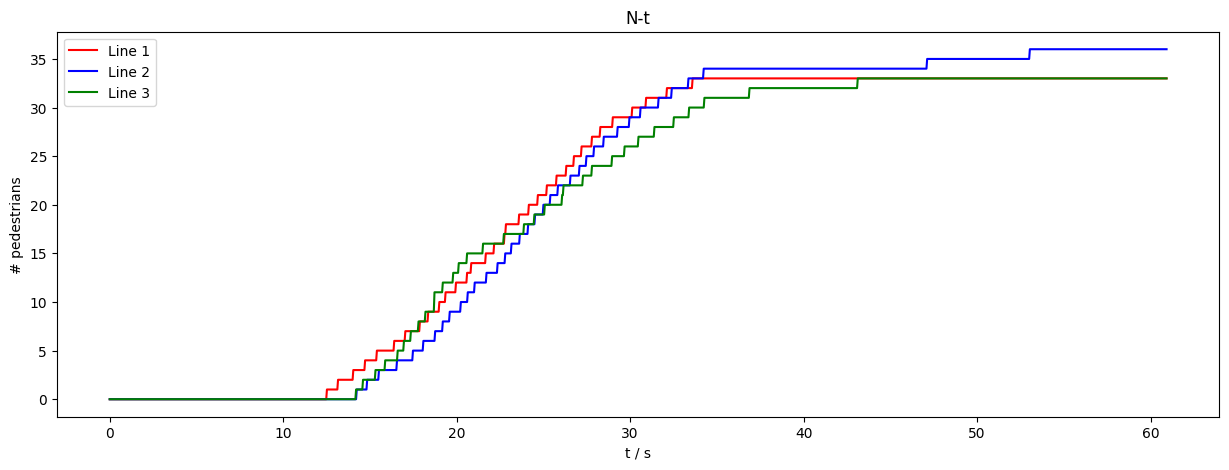

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
pedpy.plot_nt(axes=ax, nt=cp1, label="Line 1", color="red")
pedpy.plot_nt(axes=ax, nt=cp2, label="Line 2", color="blue")
pedpy.plot_nt(axes=ax, nt=cp3, label="Line 3", color="green")
ax.legend();